In [1]:
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, time, timedelta
from sklearn.model_selection import train_test_split
from optimal_f import OptimalF
from joblib import Parallel, delayed

In [2]:
def summarize_trade_results(trade_results, strategy_name):
    total_win = sum(x for x in trade_results['profits'] if x > 0)
    total_loss = -sum(x for x in trade_results['profits'] if x < 0)
    profit_factor = total_win / total_loss if total_loss != 0 else 0

    long_win_rate = sum(1 for x in trade_results['long_profits'] if x > 0) / len(trade_results['long_profits']) if trade_results['long_profits'] else 0
    short_win_rate = sum(1 for x in trade_results['short_profits'] if x > 0) / len(trade_results['short_profits']) if trade_results['short_profits'] else 0
    net_profit = sum(trade_results['profits'])

    # Print and log the statistics
    lines = [
        f"Strategy: {strategy_name}",
        f"Total trade Num: {len(trade_results['profits'])}",
        f"Net Profit: {net_profit:.2f}",
        f"Profit Factor: {profit_factor:.2f}",
        f"Long Trade Num: {len(trade_results['long_profits'])}",
        f"Long Win Rate: {long_win_rate:.2f}",
        f"Short Trade Num: {len(trade_results['short_profits'])}",
        f"Short Win Rate: {short_win_rate:.2f}\n"
    ]
    
    for line in lines:
        print(line)
        logging.info(line)

    # Create cumulative return series
    cumulative_returns = np.cumsum(trade_results['profits'])
    cumulative_long_returns = np.cumsum(trade_results['long_profits'])
    cumulative_short_returns = np.cumsum(trade_results['short_profits'])

    # Plot the results
    plt.figure(figsize=(10,6))
    plt.plot(cumulative_returns, label='Total Returns')
    plt.title("Cumulative Total Returns")
    plt.xlabel("Trade")
    plt.ylabel("Cumulative Return")
    plt.grid(True)
    plt.show()
    
    plt.figure(figsize=(10,6))
    plt.plot(cumulative_long_returns, label='Long Returns', color='blue')
    plt.plot(cumulative_short_returns, label='Short Returns', color='red')
    plt.title("Cumulative Long and Short Returns")
    plt.xlabel("Trade")
    plt.ylabel("Cumulative Return")
    plt.legend()
    plt.grid(True)
    plt.show()

In [3]:
# parameters
COMMISSION_RATE = 0.001  # 例: 0.1%の手数料

# Indicator
from ta.momentum import RSIIndicator
from ta.volatility import AverageTrueRange

from sklearn.linear_model import LinearRegression

def prepare_data(df, window=3000, threshold=0.05):
    # Calculate moving averages
    df['short_ma'] = df['close'].rolling(window=50).mean()
    df['long_ma'] = df['close'].rolling(window=200).mean()

    # Determine the trend using linear regression
    df['trend'] = 0
    for i in range(window - 1, len(df)):
        y = df['close'].iloc[i - window + 1:i + 1].values.reshape(-1, 1)
        X = np.arange(window).reshape(-1, 1)
        model = LinearRegression()
        model.fit(X, y)
        slope = model.coef_[0][0]
        
        # Threshold for determining trend
        if slope > threshold:
            df.loc[i, 'trend'] = 1
        elif slope < -threshold:
            df.loc[i, 'trend'] = -1

    rsi_indicator = RSIIndicator(close=df['close'])
    df['RSI'] = rsi_indicator.rsi()
    average_true_range = AverageTrueRange(
        high=df['high'],
        low=df['low'],
        close=df['close'],
        window=14
    )
    df['ATR'] = average_true_range.average_true_range()
    
    return df

# trade logic
def trade_conditions1(df, i, portfolio): 
    rsi = df.loc[i, 'RSI']
    trend = df.loc[i, 'trend']

    if portfolio['position'] == 'long' and rsi > 70:
        return 'exit_long'
    elif portfolio['position'] == 'short' and rsi < 20:
        return 'exit_short'
    elif rsi < 20 and trend == -1:
        return 'entry_long'
    elif rsi > 70 and trend == 1:
        return 'entry_short'
    else:
        return None
    
# trade logic
def trade_conditions2(df, i, portfolio): 
    rsi = df.loc[i, 'RSI']
    trend = df.loc[i, 'trend']

    if portfolio['position'] == 'long' and rsi > 70:
        return 'exit_long'
    elif portfolio['position'] == 'short' and rsi < 20:
        return 'exit_short'
    elif rsi < 20 and trend == 1: # 売られすぎた後にトレンドが変換したと仮定
        return 'entry_long'
    elif rsi > 70 and trend == -1: # 買われすぎた後にトレンドが変換したと仮定
        return 'entry_short'
    else:
        return None
    
# trade logic
def trade_conditions3(df, i, portfolio): 
    rsi = df.loc[i, 'RSI']
    trend = df.loc[i, 'trend']
    close = df.loc[i, 'close']

    # 利確と損切りの閾値
    TAKE_PROFIT = 10
    STOP_LOSS = -10

    if portfolio['position'] == 'long':
        profit = (close - portfolio['entry_price']) * (1 - COMMISSION_RATE)
        if profit > TAKE_PROFIT or profit < STOP_LOSS:
            return 'exit_long'
    elif rsi < 20 and trend == 1:
        return 'entry_long'
    else:
        return None
    

def trade_conditions4(df, i, portfolio): 
    rsi = df.loc[i, 'RSI']
    trend = df.loc[i, 'trend']
    close = df.loc[i, 'close']

    # 利確と損切りの閾値
    TAKE_PROFIT = 10
    STOP_LOSS = -10

    if portfolio['position'] == 'short':
        profit = (portfolio['entry_price'] - close) * (1 - COMMISSION_RATE)
        if profit > TAKE_PROFIT or profit < STOP_LOSS:
            return 'exit_short'
    elif rsi > 60 and trend == -1:
        return 'entry_short'
    else:
        return None
    

# close が 200MAを上抜けたら　追随してlong (ATR利確・損切り)
def trade_conditions5(df, i, portfolio): 
    atr = df.loc[i, 'ATR']
    long_ma = df.loc[i, 'long_ma']
    close = df.loc[i, 'close']

    prev_close = df.loc[i - 1, 'close'] if i > 0 else None
    prev_long_ma = df.loc[i - 1, 'long_ma'] if i > 0 else None

    # 利確と損切りの閾値
    TAKE_PROFIT = atr * 2
    STOP_LOSS = atr * -1

    if portfolio['position'] == 'long':
        profit = (close - portfolio['entry_price']) * (1 - COMMISSION_RATE)
        if profit > TAKE_PROFIT or profit < STOP_LOSS:
            return 'exit_long'
    elif prev_close is not None and prev_long_ma is not None \
         and prev_close < prev_long_ma and close > long_ma:
        return 'entry_long'
    else:
        return None
    
# close が 200MAを下抜けたら　追随してshort (ATR利確・損切り)
def trade_conditions6(df, i, portfolio): 
    atr = df.loc[i, 'ATR']
    long_ma = df.loc[i, 'long_ma']
    close = df.loc[i, 'close']

    prev_close = df.loc[i - 1, 'close'] if i > 0 else None
    prev_long_ma = df.loc[i - 1, 'long_ma'] if i > 0 else None

    # 利確と損切りの閾値
    TAKE_PROFIT = atr * 2
    STOP_LOSS = atr * -1

    if portfolio['position'] == 'short':
        profit = (portfolio['entry_price'] - close) * (1 - COMMISSION_RATE)
        if profit > TAKE_PROFIT or profit < STOP_LOSS:
            return 'exit_short'
    elif prev_close is not None and prev_long_ma is not None \
         and prev_close > prev_long_ma and close < long_ma:
        return 'entry_short'
    else:
        return None
    
# RSIの50を基点にトレード
def trade_conditions7(df, i, portfolio): 
    atr = df.loc[i, 'ATR']
    rsi = df.loc[i, 'RSI']
    close = df.loc[i, 'close']

    prev_rsi = df.loc[i - 1, 'RSI'] if i > 0 else None

    # 利確と損切りの閾値
    TAKE_PROFIT = atr * 2
    STOP_LOSS = atr * -1

    if portfolio['position'] == 'short':
        profit = (portfolio['entry_price'] - close) * (1 - COMMISSION_RATE)
        if profit > TAKE_PROFIT or profit < STOP_LOSS:
            return 'exit_short'
    elif prev_rsi is not None and 50 > prev_rsi and 50 < rsi:
        return 'entry_short'
    else:
        return None

In [4]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def plot_data(df, column_name):
    fig = make_subplots(rows=3, cols=1, shared_xaxes=True, 
                        subplot_titles=('Close Price and Moving Averages Over Time', 
                                        'RSI Over Time', 
                                        'Trend Over Time'))

    # MA
    fig.add_trace(go.Scatter(y=df['close'], mode='lines', name='Close Price'), row=1, col=1)
    fig.add_trace(go.Scatter(y=df['short_ma'], mode='lines', name='Short MA (50)', line=dict(color='green')), row=1, col=1)
    fig.add_trace(go.Scatter(y=df['long_ma'], mode='lines', name='Long MA (200)', line=dict(color='red')), row=1, col=1)

    # RSI
    fig.add_trace(go.Scatter(y=df['RSI'], mode='lines', name='RSI', line=dict(color='orange')), row=2, col=1)

    # Trend
    fig.add_trace(go.Scatter(y=df['trend'], mode='lines', name='Trend (1: Up, 0: Down)', line=dict(color='purple')), row=3, col=1)

    fig.update_layout(height=900, width=1000, showlegend=True)
    fig.show()


In [5]:
def trade_logic(df, trade_conditions_func):
    df = df.reset_index(drop=True)

    # Initialize trade_results
    trade_results = {
        'profits': [],
        'long_profits': [],
        'short_profits': [],
    }

    # Initialize portfolio state
    portfolio = {
        'position': None,  # "long" or "short"
        'entry_price': None,
        'entry_point': 0
    }

    # Loop through the data
    for i in range(0, len(df)):
        profit = 0

        data_row = df.iloc[i]
        action = trade_conditions_func(df, i, portfolio)

        if portfolio['position'] is not None:
            if action == 'exit_long':
                profit = data_row['close'] - portfolio['entry_price']
                trade_results['profits'].append(profit)
                trade_results['long_profits'].append(profit)
                portfolio = {
                    'position': None,
                    'entry_price': None,
                    'entry_point': 0
                }

            if action == 'exit_short':
                profit = portfolio['entry_price'] - data_row['close']
                trade_results['profits'].append(profit)
                trade_results['short_profits'].append(profit)
                portfolio = {
                    'position': None,
                    'entry_price': None,
                    'entry_point': 0
                }

            else:
                trade_results['profits'].append(profit)
        
        elif action == 'entry_long':
            trade_results['profits'].append(profit)
            portfolio = {
                'position': 'long',
                'entry_price': data_row['close'],
                'entry_point': i
            }

        elif action == 'entry_short':
            trade_results['profits'].append(profit)
            portfolio = {
                'position': 'short',
                'entry_price': data_row['close'],
                'entry_point': i
            }

        else:
            trade_results['profits'].append(profit)

    return trade_results

timestamp      open      high       low     close     volume
0      1685026860000  26359.26  26359.26  26351.75  26351.76   1.082382
1      1685026920000  26351.76  26351.76  26341.77  26341.77   1.711628
2      1685026980000  26341.77  26347.69  26339.15  26347.69   2.729262
3      1685027040000  26347.69  26347.69  26347.68  26347.69   0.015822
4      1685027100000  26347.69  26358.57  26347.69  26352.09   1.631779
...              ...       ...       ...       ...       ...        ...
95995  1690815300000  29304.00  29309.99  29304.00  29309.99   5.611684
95996  1690815360000  29309.99  29309.99  29307.14  29307.14   8.512038
95997  1690815420000  29307.14  29307.15  29293.46  29293.46  12.232517
95998  1690815480000  29293.46  29301.22  29293.46  29301.21   7.573589
95999  1690815540000  29301.21  29301.99  29301.21  29301.98   8.241090

[96000 rows x 6 columns]

Strategy: RSI1
Total trade Num: 76847
Net Profit: -649.35
Profit Factor: 0.94
Long Trade Num: 47
Long Win Rate: 0.66
Short Trade Num: 72
Short Win Rate: 0.68



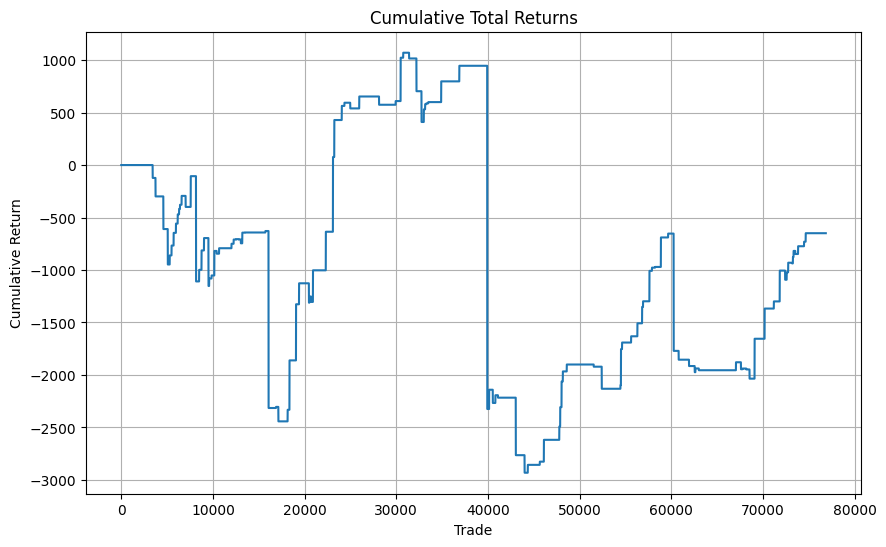

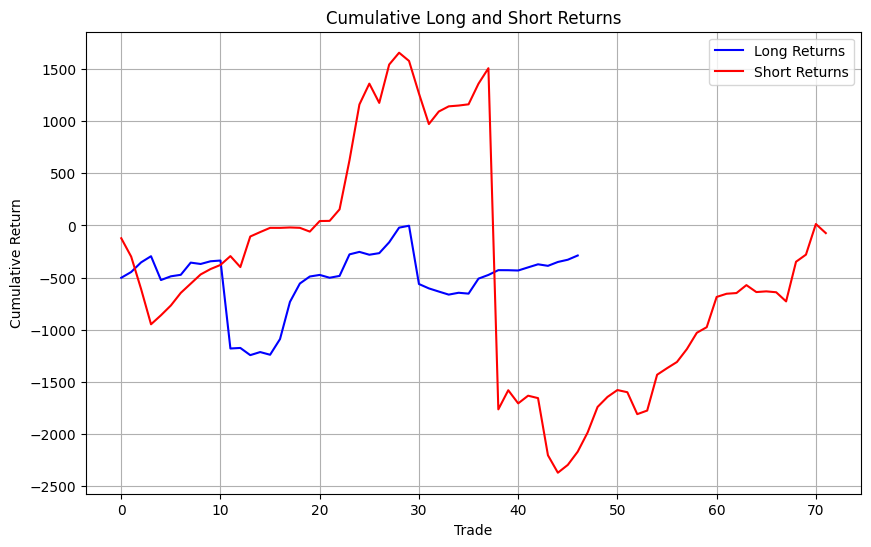

Strategy: RSI2
Total trade Num: 76866
Net Profit: 3181.18
Profit Factor: 1.40
Long Trade Num: 66
Long Win Rate: 0.79
Short Trade Num: 56
Short Win Rate: 0.57



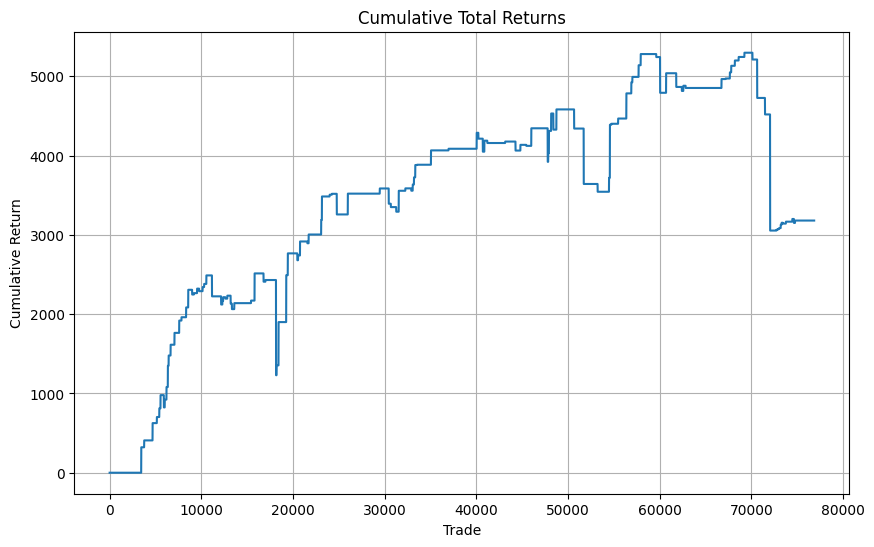

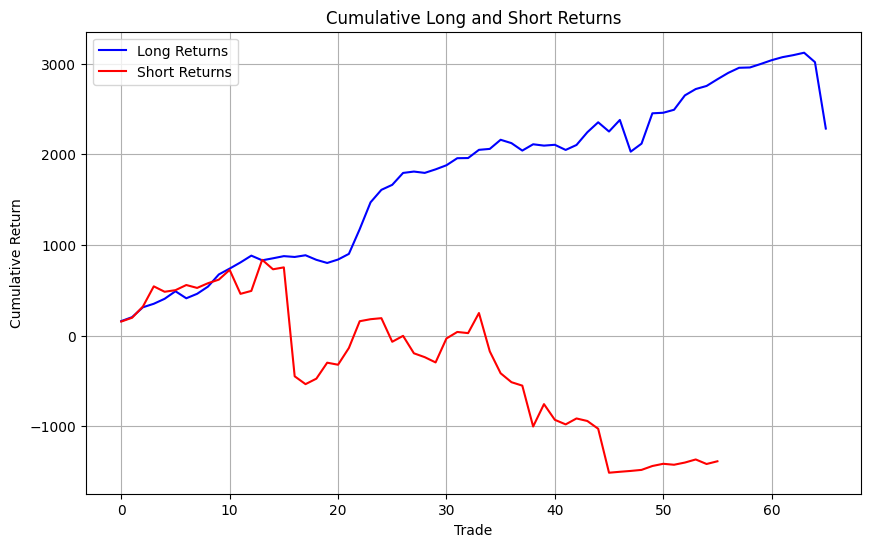

Strategy: ロングのみ
Total trade Num: 76914
Net Profit: 2397.38
Profit Factor: 2.27
Long Trade Num: 114
Long Win Rate: 0.65
Short Trade Num: 0
Short Win Rate: 0.00



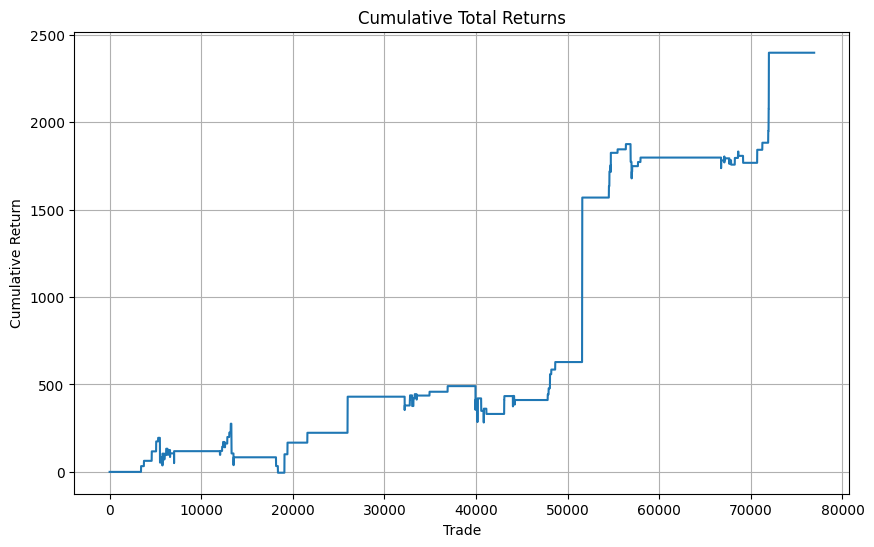

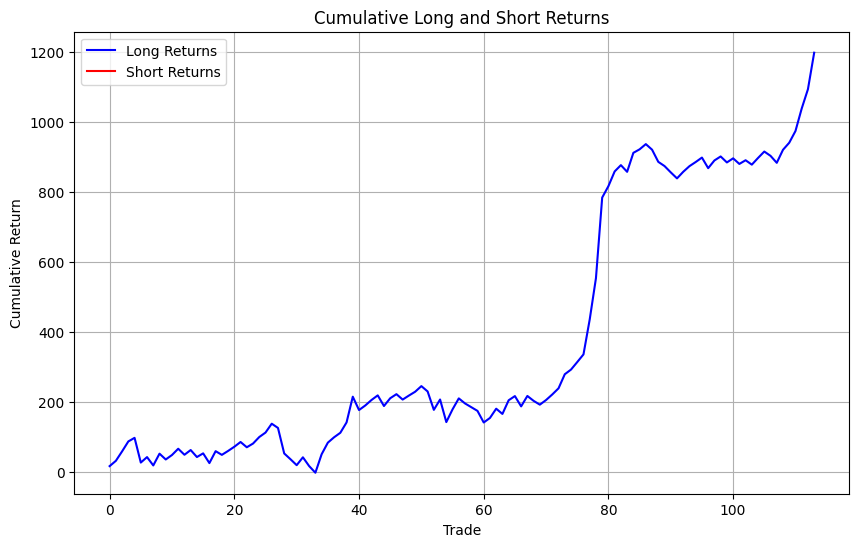

Strategy: ショートのみ
Total trade Num: 76800
Net Profit: -2466.45
Profit Factor: 0.86
Long Trade Num: 0
Long Win Rate: 0.00
Short Trade Num: 1619
Short Win Rate: 0.49



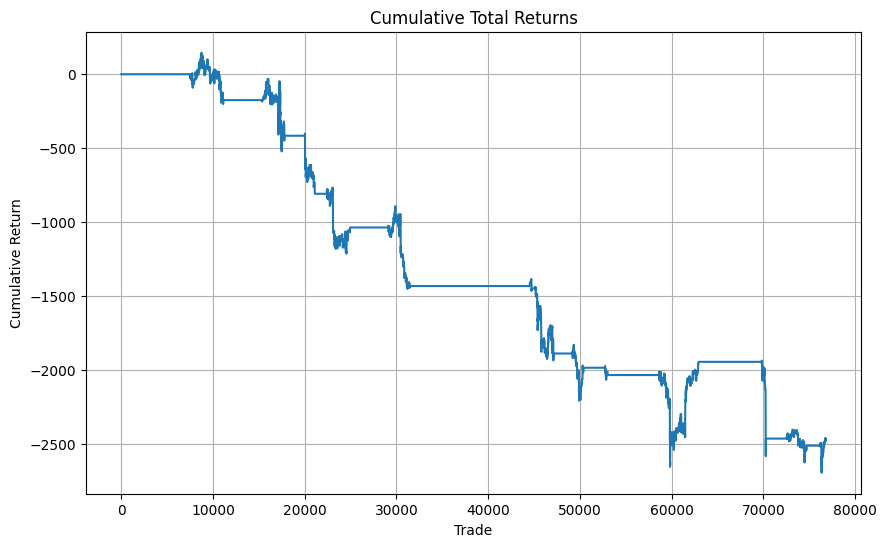

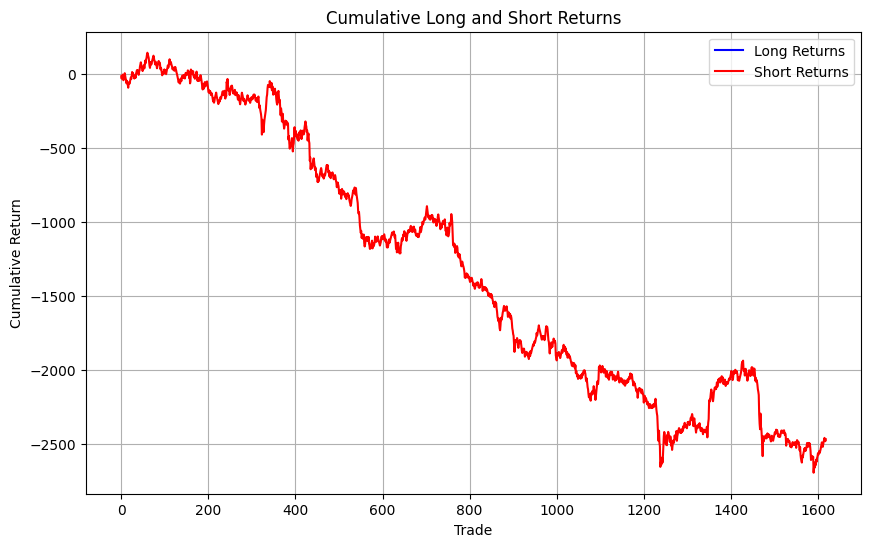

Strategy: MA1
Total trade Num: 77899
Net Profit: 3394.06
Profit Factor: 1.17
Long Trade Num: 1099
Long Win Rate: 0.45
Short Trade Num: 0
Short Win Rate: 0.00



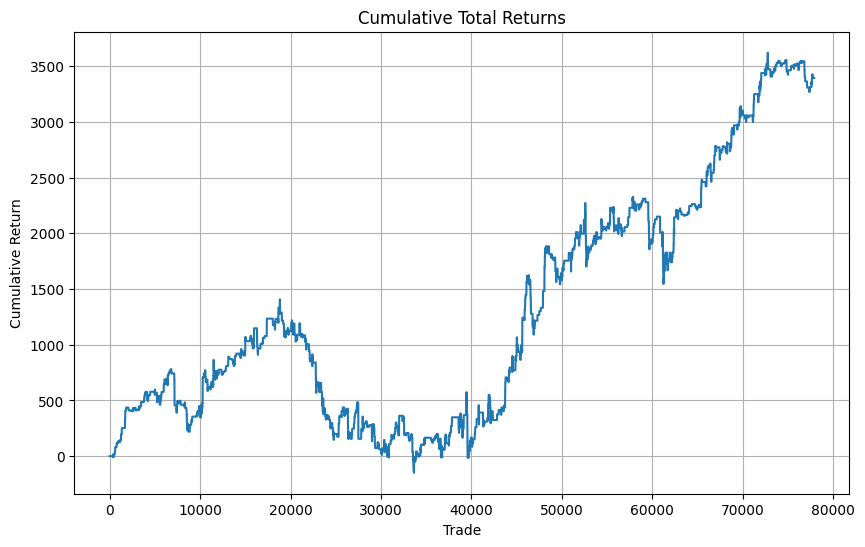

Strategy: MA2
Total trade Num: 76800
Net Profit: 1346.18
Profit Factor: 1.13
Long Trade Num: 0
Long Win Rate: 0.00
Short Trade Num: 1091
Short Win Rate: 0.42



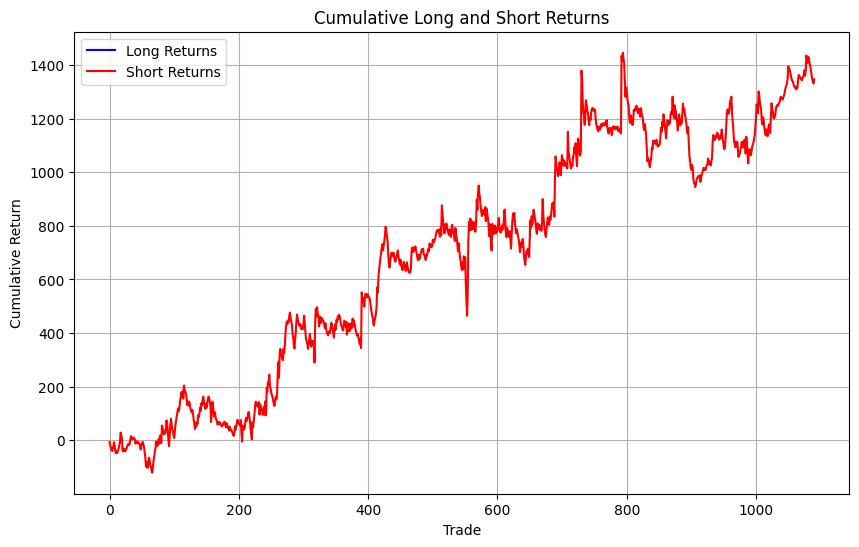

Strategy: RSI50ショート
Total trade Num: 76800
Net Profit: -914.94
Profit Factor: 0.97
Long Trade Num: 0
Long Win Rate: 0.00
Short Trade Num: 2806
Short Win Rate: 0.37



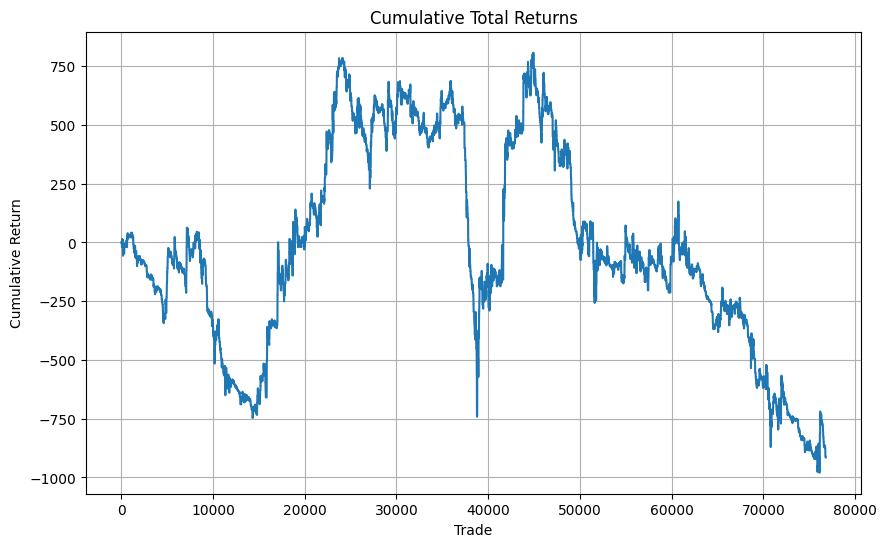

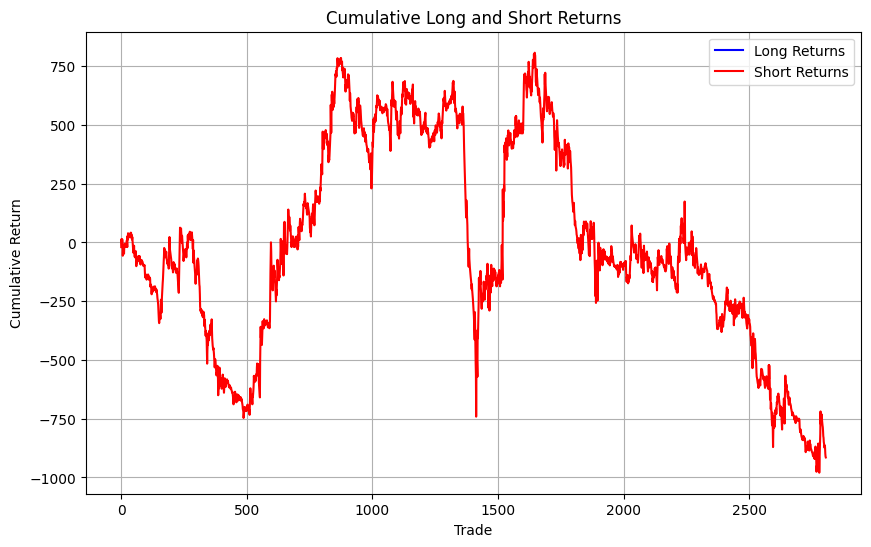

In [6]:
# Backtest
# file_name = '../csv/BTCUSDT_1m_20210801_20221231.csv'
# file_name = '../csv/BTCUSDT_1m_20230101_20230525.csv'
file_name = '../csv/BTCUSDT_1m_20230526_20230801.csv'

df = pd.read_csv(file_name) 
display(df)

# Assume 80% of the data is used for training and 20% for testing
train_df, test_df = train_test_split(df, test_size=0.2, shuffle=False)

# Generate the log filename with current timestamp
log_filename = datetime.now().strftime('../log/%Y-%m-%d-%H-%M.log')

if __name__ == '__main__':
    # Logging configuration
    logging.basicConfig(filename=log_filename, level=logging.INFO, format='%(message)s')
    logging.info(f'{file_name}\n')

    # Specify the DataFrame to be used in the backtest
    df = train_df
    # df = test_df

    # Prepare the data
    df = prepare_data(df)

    plot_data(df, 'RSI')

    # Execute the trade logic
    result1 = trade_logic(df, trade_conditions1)
    result2 = trade_logic(df, trade_conditions2)
    result3 = trade_logic(df, trade_conditions3)
    result4 = trade_logic(df, trade_conditions4)
    result5 = trade_logic(df, trade_conditions5)
    result6 = trade_logic(df, trade_conditions6)
    result7 = trade_logic(df, trade_conditions7)

    # Summarize the trade results
    summarize_trade_results(result1, "RSI1")
    summarize_trade_results(result2, "RSI2")
    summarize_trade_results(result3, "ロングのみ")
    summarize_trade_results(result4, "ショートのみ")
    summarize_trade_results(result5, "MA1")
    summarize_trade_results(result6, "MA2")
    summarize_trade_results(result7, "RSI50ショート")

    # Update OptimalF calculator with trade results and calculate optimal_f
    # opt_f_calculator.set_trade_returns(trade_results['profits'])
    # opt_f = opt_f_calculator.calculate()
    # print("Optimal f:", opt_f)

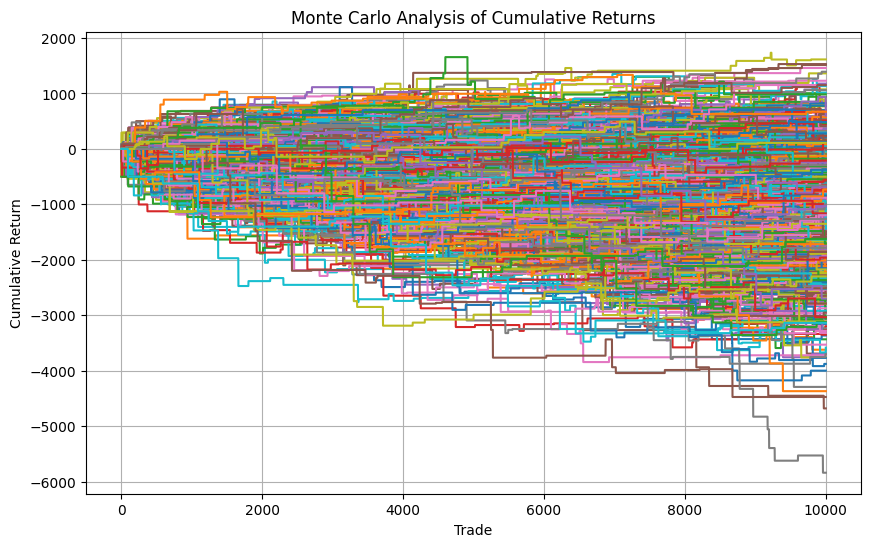

In [7]:
def monte_carlo_simulation(df, trade_conditions_func, num_simulations=1000, num_trades=10000):
    if num_trades is None:
        num_trades = len(df)
        
    df = prepare_data(df)
    original_trade_results = trade_logic(df.iloc[:num_trades], trade_conditions_func)
    profits = original_trade_results['profits']

    results = Parallel(n_jobs=-1)(delayed(run_simulation)(profits, num_trades) for _ in range(num_simulations))
    return results

def run_simulation(profits, num_trades):
    simulated_profits = np.random.choice(profits, num_trades)
    cumulative_returns = np.cumsum(simulated_profits)
    
    return cumulative_returns


df = train_df
num_simulations = 1000
results = monte_carlo_simulation(df, trade_conditions1, num_simulations)

plt.figure(figsize=(10,6))
for cumulative_returns in results:
    plt.plot(cumulative_returns)
plt.title("Monte Carlo Analysis of Cumulative Returns")
plt.xlabel("Trade")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.show()

In [8]:
import pandas as pd

def analyze_results(results, original_trade_results):
    # DataFrameの表示形式を変更
    pd.options.display.float_format = '{:.2f}'.format
    
    # 元データの計算
    original_metrics = calculate_metrics(original_trade_results['profits'])

    # シミュレーション結果の計算
    simulated_metrics = [calculate_metrics(cumulative_returns) for cumulative_returns in results]

    # 集計結果の作成
    summary = {
        '平均': {key: np.mean([metrics[key] for metrics in simulated_metrics]) for key in original_metrics},
        '標準偏差': {key: np.std([metrics[key] for metrics in simulated_metrics]) for key in original_metrics},
        '上振れ95%': {key: np.percentile([metrics[key] for metrics in simulated_metrics], 95) for key in original_metrics},
        '下振れ95%': {key: np.percentile([metrics[key] for metrics in simulated_metrics], 5) for key in original_metrics},
        '元データ': original_metrics
    }

    # DataFrameとして表示
    summary_df = pd.DataFrame(summary)
    return summary_df

def calculate_metrics(profits):
    cumulative_returns = np.cumsum(profits)
    max_drawdown = np.min(cumulative_returns - np.maximum.accumulate(cumulative_returns))
    recovery_factor = cumulative_returns[-1] / -max_drawdown if max_drawdown != 0 else np.nan

    metrics = {
        '純損益': cumulative_returns[-1],
        '期待利得': np.mean(profits),
        'プロフィットファクター': np.sum([p for p in profits if p > 0]) / -np.sum([p for p in profits if p < 0]) if np.sum([p for p in profits if p < 0]) != 0 else np.inf,
        '最大ドローダウン': max_drawdown,
        'リカバリーファクター': recovery_factor,
        'シャープレシオ': np.mean(profits) / np.std(profits)
    }
    return metrics

# 分析結果の表示
df = prepare_data(df)
original_trade_results = trade_logic(df, trade_conditions1)
summary_df = analyze_results(results, original_trade_results)
display(summary_df)


/Users/tek/dev/python/learning-model/myenv/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning:

invalid value encountered in subtract



平均       標準偏差     上振れ95%       下振れ95%     元データ
純損益         -5174892.34 5691147.69 3304581.99 -15156728.08  -649.35
期待利得            -517.49     569.11     330.46     -1515.67    -0.01
プロフィットファクター         inf        NaN      49.61         0.00     0.94
最大ドローダウン    -5875834.77 4893311.44  -43055.06 -15157152.16 -4001.57
リカバリーファクター          NaN        NaN        NaN          NaN    -0.16
シャープレシオ           -0.98       1.20       1.28        -2.70    -0.00

In [9]:
def walk_forward_test(df, optimization_window_size, validation_window_size, trade_logic_function):
    # Reset the index of the DataFrame
    df = df.reset_index(drop=True)

    # Split the DataFrame into windows
    results = []
    for i in range(0, len(df) - optimization_window_size - validation_window_size, validation_window_size):
        # Optimization window
        optimization_window = df.iloc[i:i+optimization_window_size].copy()
        optimization_window = prepare_data(optimization_window)
        # The optimal parameters can be found here (if needed)

        # Validation window
        validation_window = df.iloc[i+optimization_window_size:i+optimization_window_size+validation_window_size].copy()
        validation_window = prepare_data(validation_window)
        
        # Execute the trade logic
        result = trade_logic(validation_window, trade_logic_function)
        
        # Collect the results
        results.append(result)

    # You can aggregate the results as needed
    return results


# Set the optimization and validation window sizes
OPTIMIZATION_WINDOW_SIZE = int(len(train_df) * 0.2)
VALIDATION_WINDOW_SIZE = int(len(train_df) * 0.1)

# Execute the walk-forward test
wf_results1 = walk_forward_test(train_df, OPTIMIZATION_WINDOW_SIZE, VALIDATION_WINDOW_SIZE, trade_conditions1)
# Similarly, you can call walk_forward_test with other trade_conditions

# You can analyze the wf_results as needed


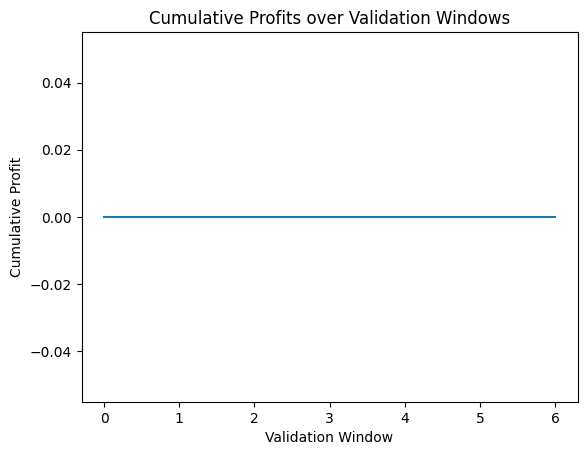

In [10]:
cumulative_profits = [sum(result['profits']) for result in wf_results1]
plt.plot(cumulative_profits)
plt.title('Cumulative Profits over Validation Windows')
plt.xlabel('Validation Window')
plt.ylabel('Cumulative Profit')
plt.show()